Readme.md  docs/      src/


 # Classifying seizures using spectral contrasting

 Ali Zaidi
 
 ### BRIEF INTRODUCTION

 Our objective is to train a classifier to detect seizures from EEG data.
 We are using a data from the Temple University dataset.
 The objective of this analysis is to demonstrate the usefulness of smart
 feature engineering. The methods have already been defined in src/data_handling.py.
 

## TABLE OF CONTENTS

### [Understanding the data](#link1)
An overview of EEG data used in this example
### [The brut-force method](#link2)
Demonstration of how throwing all the data into a classifier doesn't work. Also how PCA does reduce dimensions but still does not lead to any improvement.
### [Spectral Contrasting](#link3)
A demonstration of the intiution and use of spectral contrasting for timeseries analysis of complex signals.

In [10]:

# Import all dependencies
from sklearn import svm
import src.data_loader as dl
import time
import numpy as np
from itertools import compress
import matplotlib
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import matthews_corrcoef, make_scorer
from sklearn.neural_network import MLPClassifier
import multiprocessing
import scipy.stats
from sklearn.manifold import TSNE
import sys
from sys import getsizeof
import mpld3

# Set some params
# mpld3.enable_notebook()

In [11]:
# Import the data handling scripts and initialize the object.
import src.data_handling
dh = src.data_handling.data_handling()
dh.load_data()


Loading dataset...
A summary of valid labels is below: 
Format: [Label name, label index, Label count]
['null', 0, 879]
['bckg', 6, 6864]
['gnsz', 9, 67]
['cpsz', 11, 184]
['tcsz', 15, 6]


 ## Understanding the data <a class="anchor" id="link1"> </a>
 
 The data has beenn divided into the following objects:

 data:     timeseries data from 6 EEG channels

  labels:   a binary array identifying the epoch label. The table above summarizes the labels and their frequency. 'null' and 'bckg' are normal EEG activity. The rest are seizures. 
  
 We are interested in training a binary classifier to learn to tell these two kinds of neural signatures apart.

In [12]:
# The dataset is arranged as an array with shape channels x timeseries x epochs.
# Let's have a look at the shape of our data object. 
print(dh.data.shape)

(6, 500, 8000)


In [13]:
# There are 8000 epochs of 6 channels sampled at 500 Hz.
# Let's write a method to plot timeseries data from an epoch:
def plot_epoch(epoch):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,12))
    for ax, ch in zip(axes.ravel(), range(6)):
        plt.subplot(ax)
        plt.title('Channel {}'.format(ch))
        plt.plot(np.linspace(0, 999, num=500), dh.data[ch, :, epoch])
        plt.xlabel('time (ms)')

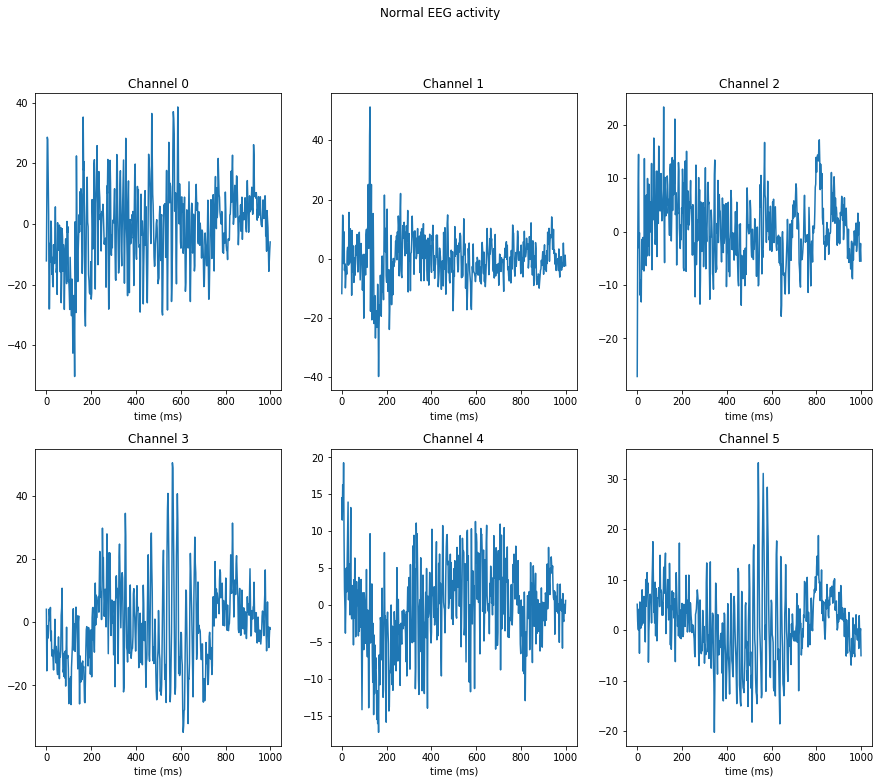

In [14]:
# Let's have a look at a normal EEG signal
null = [epoch for epoch in range(dh.labels.shape[0]) if dh.labels[epoch, 0] >0]

plot_epoch(null[0])
plt.suptitle('Normal EEG activity'); plt.show()

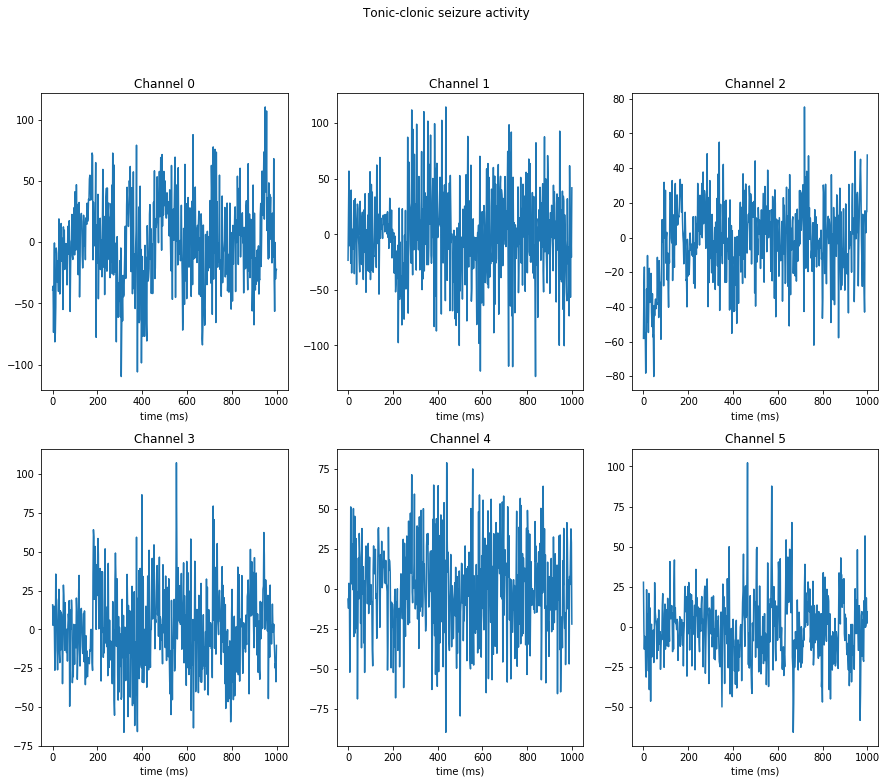

In [151]:
# Now let's look at a seizure. Let's take a tonic-clonic seizure (label index 15)

# Lets get all the epochs with that label
tcsz = [epoch for epoch in range(dh.labels.shape[0]) if dh.labels[epoch, 15] >0]
plot_epoch(tcsz[1])
plt.suptitle('Tonic-clonic seizure activity'); plt.show()

## The brut-force method <a class="anchor" id="link2"> </a>

The simplest approac (in terms of implementation) would be to try to use the entire timeseries data as the feature vector. You just throw the dataset at a classifier and see what happens. You don't need any prior knowledge of the dataset, timeseries analysis or what processes generated the signals.

Let's give this a try. We'll combine all the data across the channels into a single vector.

In [97]:
# First let's make matrices X and y to train an SVM on

X, y = dh.generateFullFeatures()

# The shape of our matrix would be epochs x samples
print("Shape of X is {}".format(X.shape))

# The size in kb for each vector is
X[0,:].nbytes/1024

Shape of X is (1936, 3000)


23

In [98]:
# We can split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

In [100]:
# Now let's train the SVM
scores_svm_full, clf_full = dh.classifySVM(X, y)



 Training svm on dataset


 cross-validation accuracy: 0.50 (+/- 0.00 CI)
The runtime for classifySVM took 13.5691931248 seconds to complete


That means our algorithm is performing at chance level. That's expected since we have ~1000 more features than training examples.

But! We could do a PCA on the data and reduce the dimensions. There must be a lot of redundancy across the samples in a feature vector. Let's give it a shot.

In [114]:
n_components = min(X.shape[0], X.shape[1]) - 1
pca = PCA(n_components=n_components)
X = pca.fit_transform(X, )
X.shape

(1936, 1934)

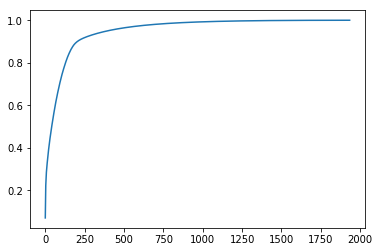

In [150]:
plt.plot(pca.explained_variance_ratio_.cumsum()); plt.show()

In [124]:
# Let's take the first 500 components

X_train, X_test, y_train, y_test = train_test_split(
    X[:,:500], y, test_size=0.2)
scores_svm_full, clf_full = dh.classifySVM(X, y)



 Training svm on dataset


 cross-validation accuracy: 0.50 (+/- 0.00 CI)
The runtime for classifySVM took 7.66475820541 seconds to complete


In [125]:
# Or the first 1000

X_train, X_test, y_train, y_test = train_test_split(
    X[:,:1000], y, test_size=0.2)
scores_svm_full, clf_full = dh.classifySVM(X, y)



 Training svm on dataset


 cross-validation accuracy: 0.50 (+/- 0.00 CI)
The runtime for classifySVM took 7.50758004189 seconds to complete


Reducing dimensions using PCA doesn't help us improve our classifier. We need something better.

## Using spectral properties

#### EEG Timeseries data can be decomposed spectrally

The spectral decomomposition obeys the power law. This means that there is an inverse log-relationship between the power of an oscillation and its frequency.

For example:

In [155]:
sig = np.abs(scipy.fftpack.fft(dh.data[0,:,0]))

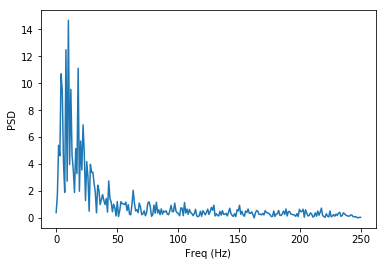

In [156]:
N = 500
T = 1000/500
x = np.linspace(0.0, N*T, N)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
plt.plot(xf*1000, 2.0/N * np.abs(sig[0:N//2]))
plt.xlabel("Freq (Hz)")
plt.ylabel("PSD")
plt.show()

## Spectral contrasting <a class="anchor" id="link3"></a>

The spectral contrasting method aims at discovering the range of frequencies that best help discriminate between two classes in a dataset. A detailed discussion of the method is beyond the scope of this tutorial.

Very simply put, we decompose each timeseries into it's spectral constituents using short-time fourier transforms. We then compute the average power for each pair of frequencies across the dataset, starting from 0 and iterating one step at a time until highest frequency. This means we have a matrix for the average power between each possible pair of frequencies. This will help us determine the pairs of frequencies that have the highest contrast (standard deviation) between the two classes.

In [24]:
# Let's start by obtaining a normalized spectrogram of the data

idx_null = [idx for idx in range(dh.labels.shape[0])if dh.labels[idx, 0] > 0]
idx_bckg = [idx for idx in range(dh.labels.shape[0]) if dh.labels[idx, 6] > 0]
np.random.shuffle(idx_bckg)
idx_bckg = idx_bckg[:800]
idx_gnsz = [idx for idx in range(dh.labels.shape[0]) if dh.labels[idx, 9] > 0]
idx_cpsz = [idx for idx in range(dh.labels.shape[0]) if dh.labels[idx, 11] > 0]
idx_tcsz = [idx for idx in range(dh.labels.shape[0]) if dh.labels[idx, 15] > 0]

# We then obtain the normalization matrix. This is the STFT averaged over the entire dataset
norm = dh.get_norm_array(dh.data)

# Next we obtain the STFT of the data corresponding to different labels.
null_stft_norm, _ = dh.get_stft(dh.data[:, :, idx_null], norm)
bckg_stft_norm, _ = dh.get_stft(dh.data[:, :, idx_bckg], norm)
gnsz_stft_norm, _ = dh.get_stft(dh.data[:, :, idx_gnsz], norm)
cpsz_stft_norm, _ = dh.get_stft(dh.data[:, :, idx_cpsz], norm)
tcsz_stft_norm, f = dh.get_stft(dh.data[:, :, idx_tcsz], norm)

### Now let's create out datasets to contrast 

We combine all the null labels into a single matrix. The shape of this matrix is nchan x ts x epochs.

We also combine all the seizure data into the same dataset.

In [32]:
# Create two datasets, one with background data and one with target data

bckg = null_stft_norm;
bckg = np.append(bckg, bckg_stft_norm, 3)

targ = gnsz_stft_norm;
targ = np.append(targ, cpsz_stft_norm, 3)
targ = np.append(targ, tcsz_stft_norm, 3)

In [40]:
# We next obtain the mean power in each pair of frequencies of the STFT.
# This is used to obtain the SNR between the two matrices

targ_bands, bckg_bands, f = dh.get_bands(baseline_array_norm=bckg, data_array_norm=targ, f=f)

In [ ]:
snr = dh.get_snr(targ_bands, bckg_bands)

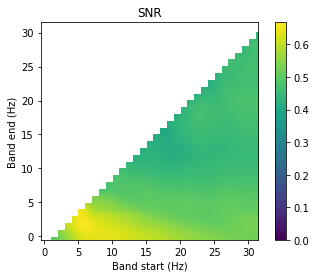

In [47]:
dh.plot_snr(snr)

### Understanding SNR

The SNR matrix displays the max SNR value for each pair of frequencies, across channels and STFT timesteps. The X-axis represents the start-band and the y-axis represents the end-badn

### Using the SNR to reduce the feature space of the dataset

We can now see that there are zones with higher SNR. We can use this information to reduce the feature space by averaging the power over multiple frequencies

In [48]:
X, y = dh.generate_dataset(normalize=False, multiclass=False)
X.shape

Generating dataset...
Generating training datasets for data...



(63888, 18)

In [49]:
scores_svm_less, clf_less = dh.classifySVM(X, y)



 Training svm on dataset


 cross-validation accuracy: 0.86 (+/- 0.01 CI)
The runtime for classifySVM took 34.311029911 seconds to complete
